<a href="https://colab.research.google.com/github/yayin07/AIFisrt_Week2_Cabiles/blob/master/Finetuning_Week2_Cabiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIBootcamp Day 2: Finetuning DeepSeek

## Introduction

This notebook serves as an instructional guide on how to train an open-source model, particularly **DeepSeek**.

The training recipe demonstrated in this guide follows the **PEFT QLoRA** (Parameter-Efficient Fine-Tuning with Quantized Low-Rank Adapters) approach.

Along the way, we'll also discuss important concepts such as **Quantization** and **Low-Rank Adapters**, which are essential for enabling efficient training on limited hardware resources.


### Installation

In [ ]:
# %%capture   # uncomment %%capture if you want silent install
import os

if "COLAB_" not in "".join(os.environ.keys()):
    # If not in Colab, install only the base 'unsloth' package using pip
    !pip install unsloth
else:
    # If in Google Colab, install all required dependencies manually
    # This avoids potential version conflicts and speeds up Colab setup
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo

    # Install additional required libraries for tokenization and dataset handling
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # Finally, install the core 'unsloth' package without pulling in its dependencies again
    !pip install --no-deps unsloth

<sub>

### Why these dependencies are needed:

- `bitsandbytes`: Enables 8-bit and 4-bit quantization for model weights, crucial for memory efficiency during fine-tuning.
- `accelerate`: Helps manage multi-GPU and mixed-precision training with simple configurations.
- `xformers==0.0.29.post3`: Provides optimized attention implementations for faster and more memory-efficient transformer operations.
- `peft`: Parameter-Efficient Fine-Tuning library from Hugging Face; essential for techniques like LoRA and QLoRA.
- `trl==0.15.2`: The Transformers Reinforcement Learning library, used for advanced fine-tuning methods such as DPO and PPO.
- `triton`: Compiler used to accelerate custom GPU kernels, often required for fused optimizations.
- `cut_cross_entropy`: A CUDA-accelerated loss function optimized for large language model training.
- `unsloth_zoo`: Contains prepackaged models and utilities specific to Unsloth’s ecosystem.

#### Additional libraries:
- `sentencepiece`: Required for tokenization of many models like LLaMA, Mistral, and DeepSeek.
- `protobuf`: Protocol buffers library; needed for compatibility with Hugging Face and TensorFlow serialization formats.
- `datasets>=3.4.1`: Hugging Face's datasets library for easy dataset loading, preprocessing, and streaming.
- `huggingface_hub`: Interfaces with the Hugging Face Model Hub to download and push models/datasets.
- `hf_transfer`: Enables faster model and dataset downloads from the Hugging Face Hub, especially helpful in Colab.

#### Final step:
- `unsloth` (with `--no-deps`): Installing it last without dependencies ensures the manually specified versions above are preserved and prevents `pip` from overriding them.

</sub>


### Unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",    # <<<<<<<<<< Uncomment me
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.5.5: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<sub>

### 🧠 About `fourbit_models`

The `fourbit_models` list contains a **non-exhaustive selection** of open-source language models that are pre-quantized in 4-bit. These models are optimized for:

- **Faster download speeds**
- **Lower memory usage**
- **Reduced risk of out-of-memory (OOM) errors**

They include high-performing models from LLaMA 3.1, Mistral, Phi, and Gemma families. For a full and up-to-date list of supported 4-bit models, you can visit [Unsloth’s Hugging Face page](https://huggingface.co/unsloth).

---

### 🧪 About `model, tokenizer = FastLanguageModel.from_pretrained(...)`

In this notebook, we will be using **`unsloth/DeepSeek-R1-Distill-Llama-8B`** — a distilled version of DeepSeek built on top of LLaMA, optimized for efficient fine-tuning.

Other versions of DeepSeek you may consider exploring include:
- `deepseek-ai/deepseek-llm-7b-base`
- `deepseek-ai/deepseek-llm-7b-instruct`
- `deepseek-ai/deepseek-llm-67b-base`
- `deepseek-ai/deepseek-coder-6.7b-base`
- `deepseek-ai/deepseek-coder-33b-instruct`

This gives you flexibility in choosing a model based on task requirements, hardware constraints, and training goals.

</sub>

<sub>

### 📘 Summary: DeepSeek-R1 Evolution and Distilled Variants

**🧪 R1-Zero (Experimental Stage)**  
DeepSeek-R1 began with **R1-Zero**, a model trained purely through reinforcement learning (RL). While this resulted in strong logical reasoning, it suffered from poor structure, hard-to-read outputs, and inconsistent language use, limiting its practicality.

**🔁 R1 (Improved Stage)**  
To fix these issues, **DeepSeek-R1** adopted a hybrid approach: combining RL with **supervised fine-tuning** using curated datasets. This dramatically improved clarity, coherence, and language consistency — making it viable for real-world applications.

---

### 🧬 Distilled Models of DeepSeek-R1

**🧪 What is Distillation?**  
Model distillation reduces size and resource needs while retaining much of the parent model’s reasoning power. DeepSeek distilled R1 using both **Qwen** and **LLaMA** architectures.

---

#### 🔹 **Qwen-based Distilled Models** (Focus on efficiency)

- **Qwen-1.5B**: Compact, scores well on MATH-500 (83.9%) but weak in coding (LiveCodeBench 16.9%).
- **Qwen-7B**: Balanced reasoning with good math (92.8%) and factual QA (GPQA 49.1%), limited coding (37.6%).
- **Qwen-14B**: Strong math (93.9%) and factual skills (GPQA 59.1%), better at coding (53.1%) but not ideal for advanced programming.
- **Qwen-32B**: Best among Qwen models; excels in math (AIME 72.6%, MATH-500 94.3%) and factual QA (GPQA 62.1%), decent coding (LiveCodeBench 57.2%).

---

#### 🔹 **LLaMA-based Distilled Models** (Focus on performance)

- **Llama-8B**: Solid math (89.1%) and factual reasoning (GPQA 49.0%), weaker coding (39.6%).
- **Llama-70B**: Best performer overall — top math (MATH-500 94.5%, AIME 86.7%), strong coding (57.5%), competitive with GPT-4o in math/coding tasks.

---

🔗 _For more details, refer to the [DeepSeek release paper](https://huggingface.co/deepseek-ai)._  

</sub>



# Inference before Finetuning

In [ ]:
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:

### Question:
{}

### Response:
<think>{}"""

# Creating a test medical question for inference
question = """What is flower'?"""

# Enable optimized inference mode for Unsloth models (improves speed and efficiency)
FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!

# Format the question using the structured prompt (`prompt_style`) and tokenize it
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")  # Convert input to PyTorch tensor & move to GPU

# Generate a response using the model
outputs = model.generate(
    input_ids=inputs.input_ids, # Tokenized input question
    attention_mask=inputs.attention_mask, # Attention mask to handle padding
    max_new_tokens=1200, # Limit response length to 1200 tokens (to prevent excessive output)
    use_cache=True, # Enable caching for faster inference
)

# Decode the generated output tokens into human-readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the relevant response part (after "### Response:")
print(response[0].split("### Response:")[1])


<think>
Okay, so I need to figure out what "flower'" means. Hmm, the apostrophe at the end is a bit confusing. Maybe it's a typo or something. Let me think about it step by step.

First, "flower" is a noun that refers to the blooming part of a plant. It's commonly used in contexts like botany, gardening, or poetry. But why the apostrophe? Maybe it's possessive, like "flower's" something. But that doesn't quite make sense.

Wait, could it be part of a word? Like, if it's "flower's" something else, but without the rest of the word, it's hard to tell. Or maybe it's a typo and should be "flower's" or "flower's". Or perhaps it's part of a contraction, but that doesn't seem right.

Let me think about other possibilities. Maybe it's a plural, but "flower's" doesn't sound right in plural form. Or maybe it's a possessive form, but without a subject, it's unclear.

Alternatively, could it be a typo for "flower's" or "flower's"? Or perhaps it's a missing character. Maybe the apostrophe is suppos

# LoRA
We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128     <<<<<<<<<< Uncomment me
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

### 🔧 LoRA (Low-Rank Adaptation) Overview

LoRA is a parameter-efficient fine-tuning method for large language models. Instead of updating all model weights, LoRA injects small trainable matrices (of rank `r`) into specific layers—reducing GPU memory usage and speeding up training. It's ideal when you're fine-tuning large models on limited hardware.

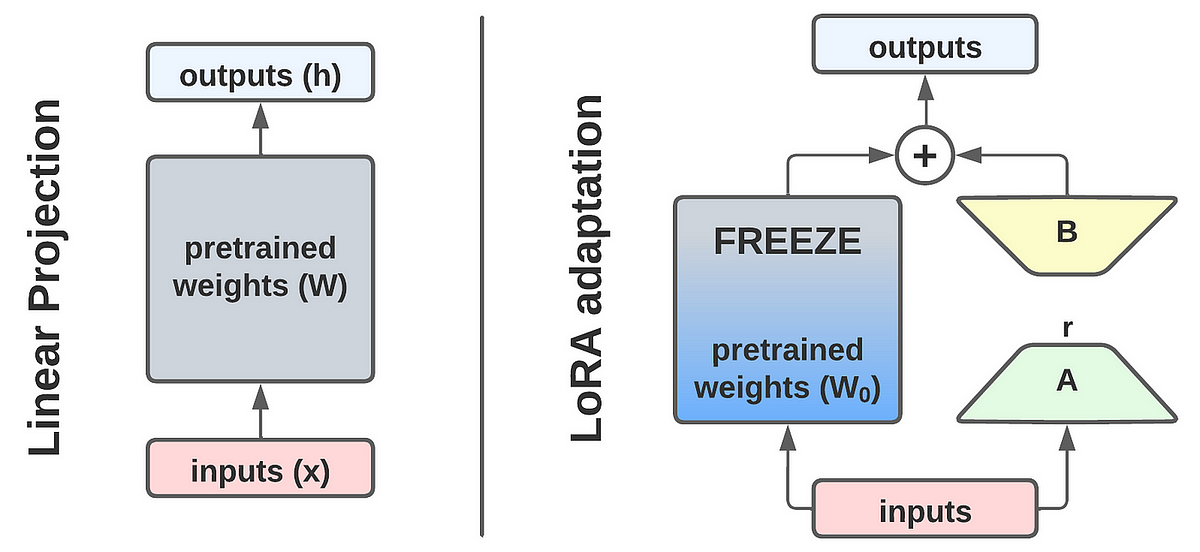


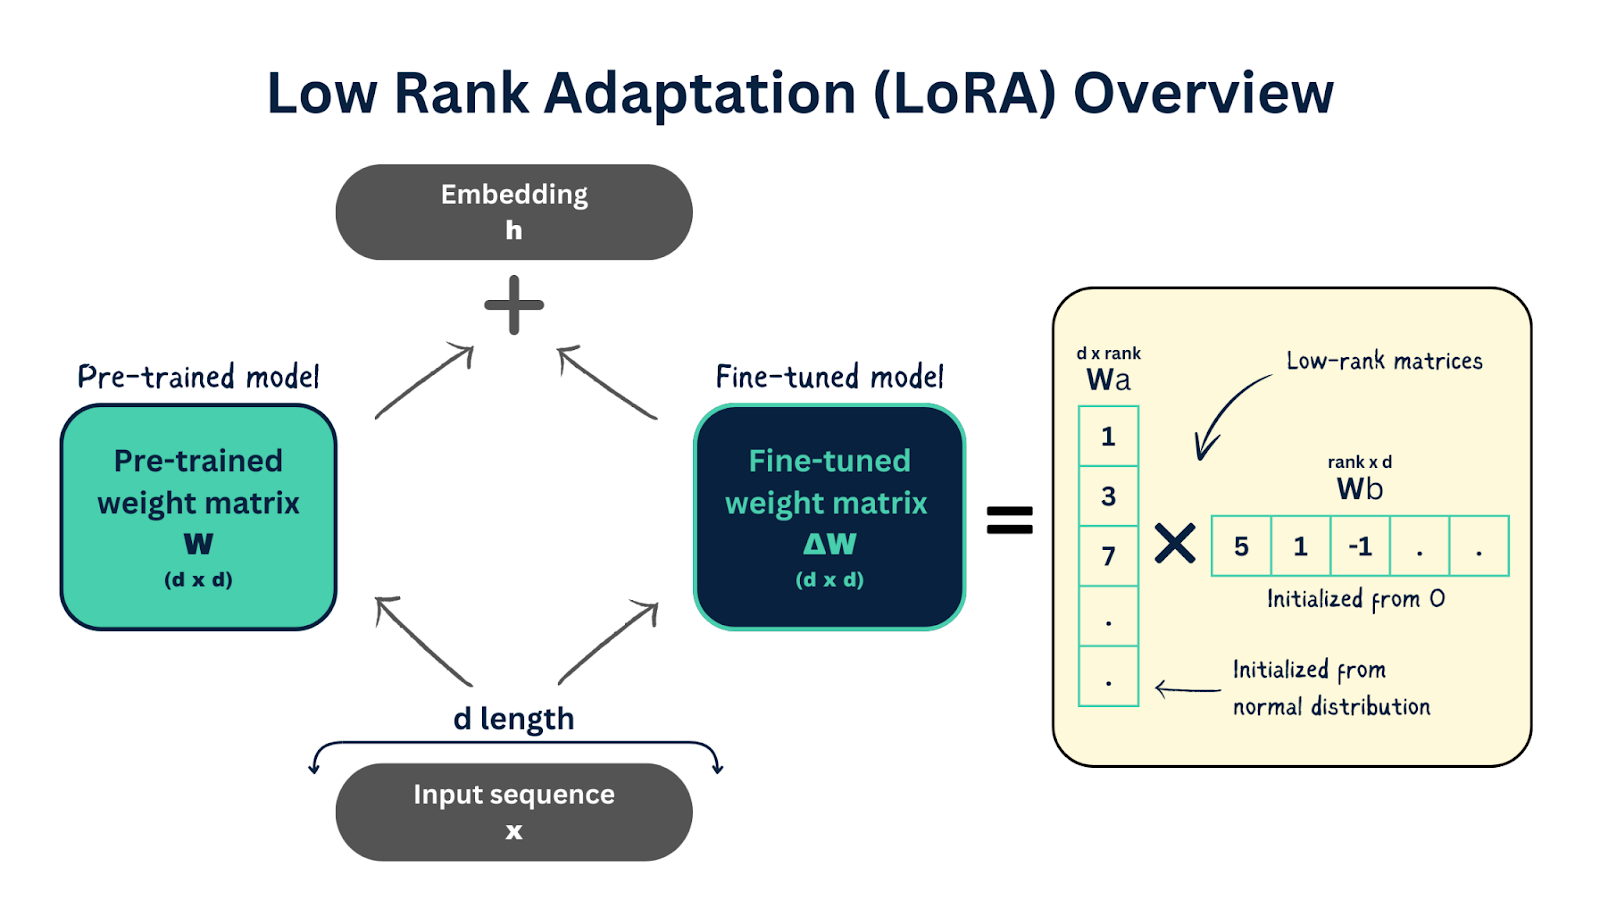

### Understanding LoRA’s Low-Rank Adaptation Mechanism

The original model weights have a large matrix:

- \( W \) with dimensions **d × d**

When fine-tuning with LoRA, instead of updating \( W \) directly, LoRA learns a smaller update matrix \( \Delta W \), also sized **d × d**.

LoRA factorizes this update into two smaller matrices:

- \( A \) with dimensions **d × r**
- \( B \) with dimensions **r × d**

By multiplying these:

\[
\Delta W = A \times B
\]

we reconstruct the update matrix \( \Delta W \) with the original size **d × d**.

Here, **r** is the *rank* of the LoRA adapter (much smaller than d), which controls how much the model can adapt.

---

**Why is this useful?**

- Instead of training \( d \times d \) parameters (which is very large), LoRA trains only the smaller matrices \( A \) and \( B \), drastically reducing the number of parameters.
- This leads to efficient fine-tuning with less memory and computation.


### 🔧 LoRA Configuration Summary

This section explains the rationale behind the LoRA settings used for efficient fine-tuning.

#### Parameters:

- **`r = 16`**
  - Sets the rank of the low-rank matrices.
  - Controls trainable parameter size.
  - Suggested values: 8, 16, 32, etc.
  - `16` is a balanced choice for performance and memory.

- **`target_modules`**
  - Modules being adapted:
    - `["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]`
  - Covers both attention and MLP layers.
  - Ensures broad adaptability across the transformer.

- **`lora_alpha = 16`**
  - Scales the LoRA updates.
  - Often matches the `r` value.
  - Helps stabilize training and balance adaptation.

- **`lora_dropout = 0`**
  - Dropout applied to LoRA layers.
  - `0` is optimized for training stability and performance.

- **`bias = "none"`**
  - LoRA does not modify bias terms.
  - Simplifies training and is usually optimal.

This setup is widely used for fine-tuning large models efficiently while preserving most of the pretrained weights.


# Data Preparation: English-Filipino Translator Prompt

- **Instruction:**  
  You are an expert English-Filipino translator with deep knowledge of language and cultural context.  
  Translate the given Filipino term or phrase into English with clear reasoning.

- **Example:**  
  - **Question:** What is the English of 'Nakakapagpabagabag'?  
  - **Chain of Thought:** Identify root word and analyze meaning (e.g., 'bagabag' means 'unsettle').  
  - **Response:** The English of 'Nakakapagpabagabag' is 'unsettling'.

- Use this format to create training samples with step-by-step reasoning and accurate translations.


In [ ]:
# dataset

In [ ]:
# print(type(dataset))

In [ ]:
from datasets import load_dataset

# Load CSV file into a Hugging Face Dataset
dataset = load_dataset('csv', data_files='/content/data_fruits_Cabiles.csv')['train']

# Check the type
print(type(dataset))  # should output: <class 'datasets.arrow_dataset.Dataset'>


<class 'datasets.arrow_dataset.Dataset'>


In [66]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are an expert translator fluent in both English and Filipino, with deep understanding of linguistic nuances, cultural context, and accurate translation techniques.
Please translate the given Filipino term or phrase into English with clear explanation and reasoning.

### Question:
{}

### Response:
<think>
{}
</think>
{}"""

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN


def formatting_prompts_func(examples):
    inputs = examples["Question"]
    cots = examples["Cot"]
    outputs = examples["Response"]
    texts = []
    for input, cot, output in zip(inputs, cots, outputs):
        text = train_prompt_style.format(input, cot, output) + EOS_TOKEN
        texts.append(text)
    return {
        "text": texts,
    }

dataset = dataset.map(formatting_prompts_func, batched = True,)
# dataset["text"][0]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
11.994 GB of memory reserved.


In [63]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11 | Num Epochs = 60 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,2.969800
2,2.854500
3,2.905600
4,2.603900
5,2.316500
6,1.959200
7,1.431500
8,1.043100
9,0.702900
10,0.460700


Step,Training Loss
1,2.969800
2,2.854500
3,2.905600
4,2.603900
5,2.316500
6,1.959200
7,1.431500
8,1.043100
9,0.702900
10,0.460700


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Unsloth_Studio.ipynb)**

In [64]:
question = """What is flower '?"""


# Load the inference model using FastLanguageModel (Unsloth optimizes for speed)
FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    use_cache=True,                        # Enable cache for efficient generation
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Response:")[1])


<think>
Flower is the part of a plant that produces fruit and is often colorful and fragrant. It is the site of seed formation.
</think>
Flower is the part of a plant where seeds are made, often colorful and sweet.<｜end▁of▁sentence｜>


In [65]:
question = """What is flower'?"""


# Load the inference model using FastLanguageModel (Unsloth optimizes for speed)
FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")


from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<｜begin▁of▁sentence｜>Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:

### Question:
What is flower'?

### Response:
<think>
Flower is a part of a plant that creates flowers. Flowers have petals and grow in different shapes and colors.
</think>
Flower is a part of a plant that creates flowers, which have petals in various shapes and colors.<｜end▁of▁sentence｜>
